In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import os
from datetime import datetime

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
df = pd.read_csv("MicrosoftStock.csv")
df 

,index,date,open,high,low,close,volume,Name
0,390198,2013-02-08,27.35,27.710,27.3100,27.55,33318306,MSFT
1,390199,2013-02-11,27.65,27.920,27.5000,27.86,32247549,MSFT
2,390200,2013-02-12,27.88,28.000,27.7500,27.88,35990829,MSFT
3,390201,2013-02-13,27.93,28.110,27.8800,28.03,41715530,MSFT
4,390202,2013-02-14,27.92,28.060,27.8700,28.04,32663174,MSFT
...,...,...,...,...,...,...,...,...
1254,391452,2018-02-01,94.79,96.070,93.5813,94.26,47227882,MSFT
1255,391453,2018-02-02,93.64,93.970,91.5000,91.78,47867753,MSFT
1256,391454,2018-02-05,90.56,93.240,88.0000,88.00,51031465,MSFT
1257,391455,2018-02-06,86.89,91.475,85.2500,91.33,67998564,MSFT


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB


In [6]:
df.describe()

,index,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,390827.000000,51.026394,51.436007,50.630397,51.063081,3.386946e+07
std,363.586303,14.859387,14.930144,14.774630,14.852117,1.958979e+07
min,390198.000000,27.350000,27.600000,27.230000,27.370000,7.425603e+06
25%,390512.500000,40.305000,40.637500,39.870000,40.310000,2.254879e+07
50%,390827.000000,47.440000,47.810000,47.005000,47.520000,2.938758e+07
75%,391141.500000,59.955000,60.435000,59.275000,59.730000,3.842024e+07
max,391456.000000,95.140000,96.070000,93.720000,95.010000,2.483542e+08


In [7]:
df.isna().sum()

index     0
date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

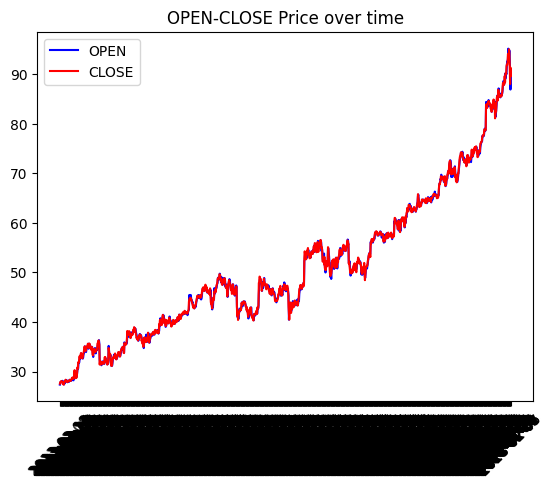

In [8]:
#Intialize Data Visualization
#Plot1 - Open and Close Prices of time
# plt.figure(figsize=(12,6))
plt.plot(df['date'], df['open'], label="OPEN", color='BLUE')
plt.plot(df['date'], df['close'], label="CLOSE", color='RED')

plt.title("OPEN-CLOSE Price over time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

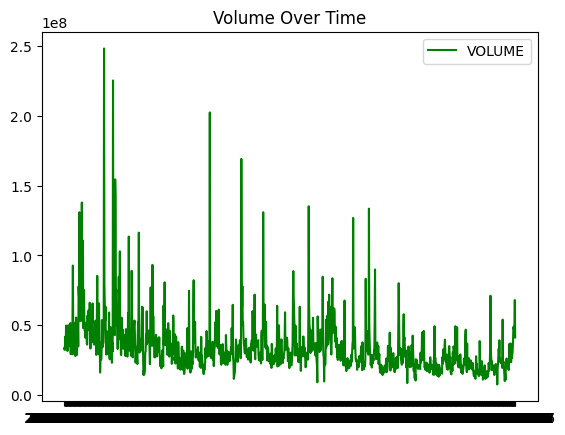

In [9]:
#Plot2 - Trading Volumes (check for Outliers)
plt.plot(df["date"], df['volume'], label="VOLUME", color="GREEN")
plt.title("Volume Over Time")
# plt.xticks(rotation=45)
plt.legend()
plt.show()

In [10]:
#Drop non numeric columns
num_df = df.select_dtypes(include=["int64","float64"])

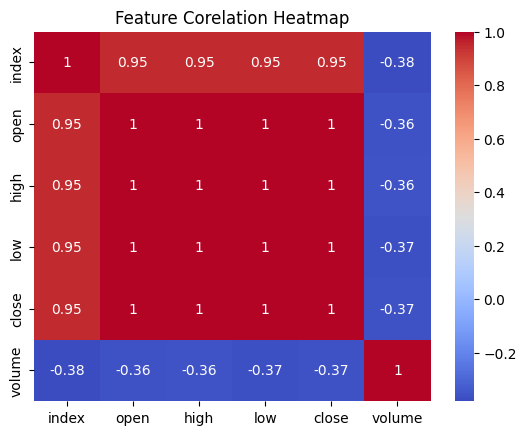

In [11]:
#Plot 3 - check for corelation btw features
sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Corelation Heatmap")
plt.show()

In [12]:
# converting the date to datetime
df['date']=pd.to_datetime(df['date'])

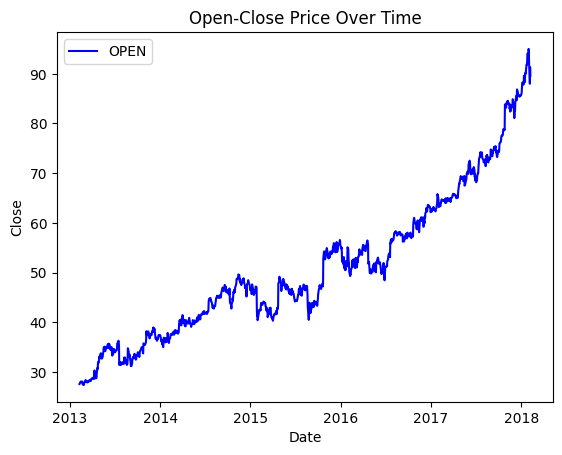

In [13]:
prediction = df.loc[
    (df['date'] > datetime(2013,1,1)) &
    (df['date'] > datetime(2018,1,1))
]

plt.plot(df['date'], df['close'], label="OPEN", color="BLUE")
plt.title("Open-Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.show()

In [14]:
# Prepare for the LSTM model (Sequential)
stock_close = df.filter(["close"])
dataset = stock_close.values.reshape(-1,1) # convert to numpy array 
training_data_len = int(np.ceil(len(dataset) * 0.95))

In [1]:
#Preprocessing Stage
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

training_data = scaled_data[: training_data_len] # 95% of all out data

X_train, y_train = [], []

NameError: name 'StandardScaler' is not defined

In [16]:
# Creating a Sliding window for our stock (60 days)

for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [25]:
#Build the Model
model = keras.models.Sequential()

#First Layer
model.add(keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1],1)))

#Second Layer
model.add(keras.layers.LSTM(64, return_sequences=False))

# Third Layer
model.add(keras.layers.Dense(128, activation='relu'))

# Forth Layer
model.add(keras.layers.Dropout(0.5))

#Final Layer
model.add(keras.layers.Dense(1))

model.summary()
model.compile(optimizer='adam', loss="mae", metrics=[keras.metrics.RootMeanSquaredError()])

training_model = model.fit(X_train, y_train,epochs = 20, batch_size = 32)

d:\ML\linear_Regression\fill\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.2313 - root_mean_squared_error: 0.3504
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.1351 - root_mean_squared_error: 0.1863
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1175 - root_mean_squared_error: 0.1588
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1179 - root_mean_squared_error: 0.1609
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.1133 - root_mean_squared_error: 0.1559
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1157 - root_mean_squared_error: 0.1568
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1080 - root_mean_squared_error: 0.1452
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.1045 - root_mean_squared_error: 0.1416
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1028 - root_mean_squared_error: 0.1417
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.1028 - root_mean_squared_error: 0.1387

In [26]:
# prep the test data 
test_data = scaled_data[training_data_len - 60:]

X_test = []
y_test = dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])

X_test = np.array(X_test)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [27]:
# Make predictions

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step


In [29]:
#Evaluate the model (RMSE)

rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("RMSE:", rmse)

RMSE: 1.772939597582914


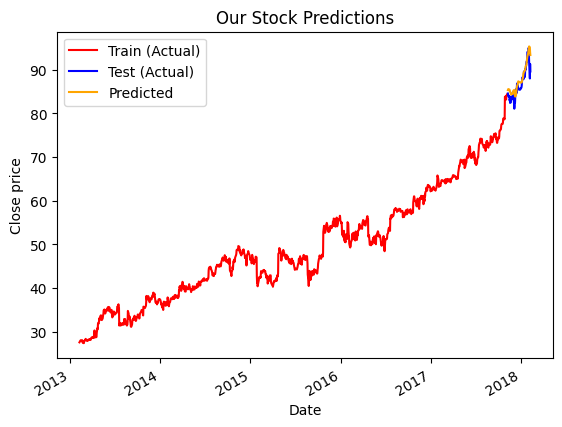

In [30]:
# Plot predictions vs actual

train = df[:training_data_len]
test = df[training_data_len:]

test= test.copy()

test['predictions'] = predictions

plt.plot(train['date'], train['close'], label='Train (Actual)', color='red')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='blue')
plt.plot(test['date'], test['predictions'], label='Predicted', color='orange' )
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close price")

plt.legend()
plt.gcf().autofmt_xdate()  
plt.show()

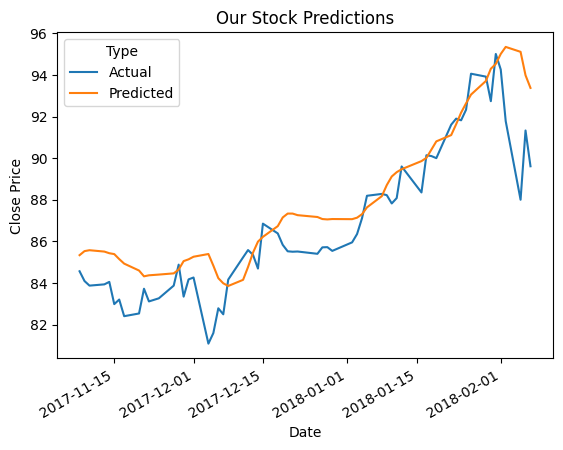

In [31]:
plot_df = pd.DataFrame({
    'Date': pd.concat([test['date'], test['date']]),
    'Close': pd.concat([test['close'], test['predictions']]),
    'Type': ['Actual']*len(test) + ['Predicted']*len(test)
})

sns.lineplot(data=plot_df, x='Date', y='Close', hue='Type')

# Customize
plt.title("Our Stock Predictions")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.gcf().autofmt_xdate()  
plt.show()